In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from skimage import io, color
from tqdm import tqdm
import random
from numpy import linalg as LA
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
image_folders = glob("./shoes/*", recursive = True)

In [3]:
def only_files(dir_path):
    return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

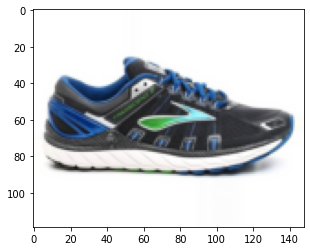

In [4]:
from skimage.transform import resize

scale_factor=0.2
image = imread(image_folders[0])
h, w, channels = image.shape
h = int(scale_factor*h)
w = int(scale_factor*w)

def get_image(image_path, scale_factor = 0.2):
    image = imread(image_path)
    h, w, channels = image.shape
    h = int(scale_factor*h)
    w = int(scale_factor*w)
    return resize(image, (h,w), anti_aliasing=True)

image = get_image(image_folders[0], scale_factor=0.2)

plt.imshow(image)

In [5]:
def extract_images(paths:list, scale_factor = 0.2):
    image = imread(paths[0])
    h, w, channels = image.shape
    h = int(scale_factor*h)
    w = int(scale_factor*w)

    A = np.zeros([len(paths), h * w * channels])
    counter = 0

    for image_path in tqdm(paths):
        im = get_image(image_path=image_path, scale_factor=scale_factor)
        if im is not None:
            A[counter, :] = im.reshape(1, -1)
            counter += 1
        else:
            continue

    return A.T

In [6]:
A = extract_images(image_folders)

100%|██████████| 337/337 [00:09<00:00, 36.18it/s]


In [7]:
A

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

The first 180 shoes are from the first class, the second 157 shoes are from the second class

In [8]:
labels = np.concatenate([np.ones(180),np.ones(157)*2])

In [9]:
test_size = 0.2

A_train, A_test, y_train, y_test = train_test_split(A.T, labels, test_size=test_size, random_state=47)

In [10]:
print("I will use {} images to train the model and {} images to validate it".format(
    len(A_train), len(A_test)
))

I will use 269 images to train the model and 68 images to validate it


In [11]:
from numpy.linalg import eig

def eigen_training(A):
    n, m = A.shape
    L = np.matmul(A.T, A)

    eigenValues, eigenVectors = eig(L)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    #U are the igenvectors in the original referiment system
    U = np.matmul(A, eigenVectors)

    for i in range(m):
        #normalize
        U[i,:] = np.linalg.norm(U[i,:])

    return (eigenValues, U)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
A_train_tilde = scaler.fit_transform(A_train)
A_test_tilde = scaler.fit_transform(A_test)



In [13]:
n_components = 50
pca = PCA(n_components=n_components)

#A_train_tilde = A_train - A_train.mean(axis=0).reshape(1,-1)
#A_test_tilde = A_test - A_test.mean(axis=0).reshape(1,-1)

drA_train = pca.fit_transform(A_train)
drA_test = pca.transform(A_test_tilde)

eigenvalues = pca.explained_variance_ratio_
eigenvectors = pca.components_

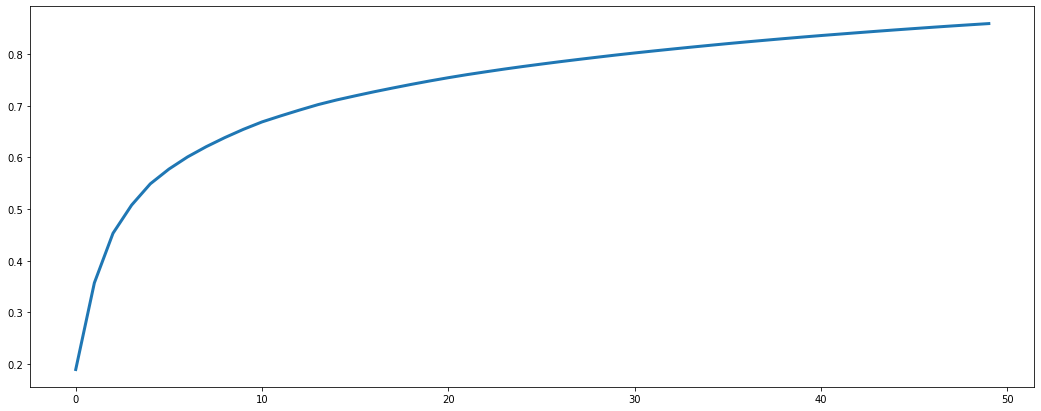

In [14]:
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
plt.show()

In [15]:
n_features = np.where(pca.explained_variance_ratio_.cumsum()>0.8)[0][0]
print("The number of features to have 80% of information is: {}".format(n_features))

The number of features to have 80% of information is: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


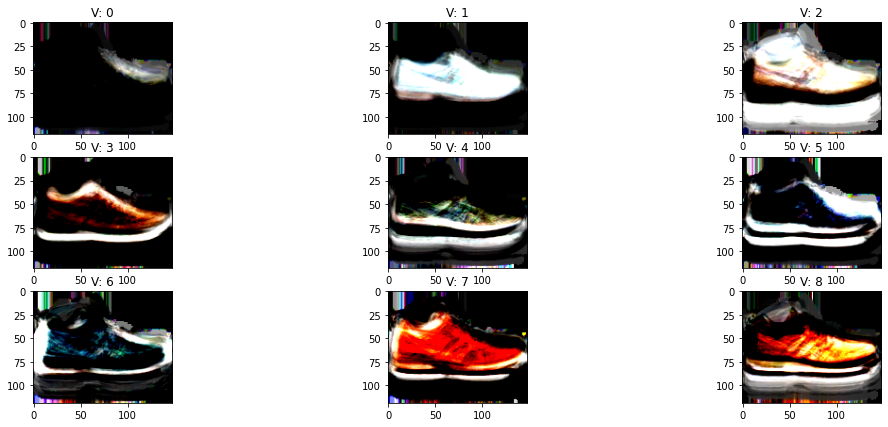

In [17]:
eigenvectors = scaler.fit_transform(eigenvectors)

plt.figure(figsize=(18, 7))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = eigenvectors[i].reshape([h, w, -1])
    ax.set_title("V: {}".format(i))
    ax.imshow(image)
plt.show()


## Bayesian Classifier

In [24]:
from Utilities.bayesian import *

In [25]:
#from Utilities.bayesian import *
classifier = BayesianClassifier(data=drA_train[:,:10], labels=y_train)

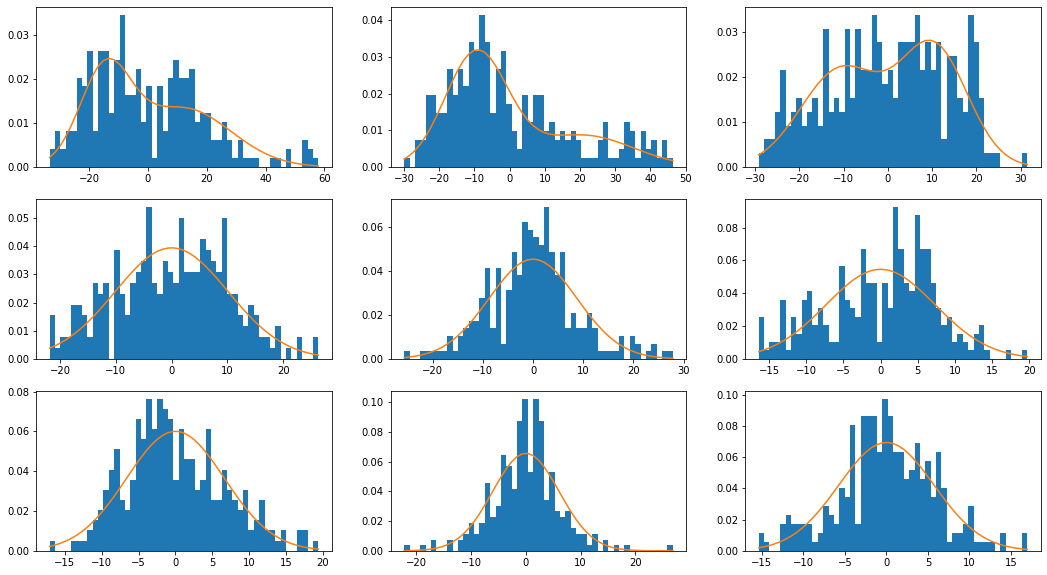

In [26]:
plt.figure(figsize=(18, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    classifier.mixture_model[i].plot_pdf_modeled(n_bins=50)
plt.show()

In [27]:
predictions, prob_dataframe = classifier.predict(data=drA_test[:,:10],y_true=y_test)

100%|██████████| 68/68 [00:00<00:00, 765.31it/s]

The score of the classifier is: 0.5588235294117647
